In [1]:
from datetime import datetime
from collections import defaultdict
import re
import pickle
import pandas as pd
from netCDF4 import Dataset, num2date #pylint: disable=no-name-in-module
import numpy as np
import numpy.ma as ma

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import scipy.optimize as opt
from scipy.stats import linregress
import seaborn as sn
import cmasher as cmr
import mpl_axes_aligner

import os
import sys
from pathlib import Path
path = Path(os.getcwd())
path_parent=str(path.parent.absolute())
path_module=path_parent+'/src/SuPerSim'
sys.path.insert(0, os.path.abspath(path_module))

from SuPerSim import get_all_stats, load_all_pickles, plot_all

In [2]:
################################################
# Here, write the paths to your own data files #
################################################

# this is just introduced for convenience
path_data = path_parent+'/examples/data/'

# those are the real variables
path_forcing_merra2 = path_data+'/scaled_merra2_Aksaut.nc'
path_ground = path_data+'North/result_soil_temperature.nc'
path_snow = path_data+'North/result_snow_depth.nc'
path_swe = path_data+'North/result_swe.nc'
path_thaw_depth = path_data+'North/result_thaw_depth.nc'
path_repository = path_data+'North/folder_manifest.csv'
path_pickle = path_parent+'/examples/python_pickles/'

path_horizon = path_data+'/horizon.csv'

###############################################################
# Enter the parameters of your site and of the rockfall event #
###############################################################

site = 'Aksaut_North'
year_bkg_end = 2010
year_trans_end = 2023
forcing_list = ['merra2']
path_forcing_list = [path_forcing_merra2]
date_event = [2021, 12, 31]
topo_event = []
no_weight = True
consecutive = 7
glacier = False
min_glacier_depth = 100

Succesfully opened the pre-existing pickle: df_Aksaut_North.pkl
Succesfully opened the pre-existing pickle: reanalysis_stats_Aksaut_North.pkl
Succesfully opened the pre-existing pickle: list_valid_sim_Aksaut_North.pkl
Succesfully opened the pre-existing pickle: melt_out_Aksaut_North.pkl
Succesfully opened the pre-existing pickle: df_stats_Aksaut_North.pkl
Succesfully opened the pre-existing pickle: rockfall_values_Aksaut_North.pkl

---------------------------------------------------------------------------------------------

Fisheye view of the sky with the visible portion in blue and the blocked one in black:


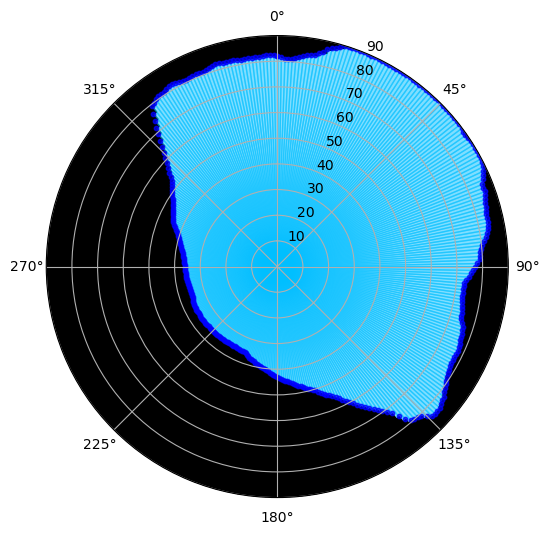


---------------------------------------------------------------------------------------------

The following plot is a histogram of the distribution of the statistical weights of all simulations:


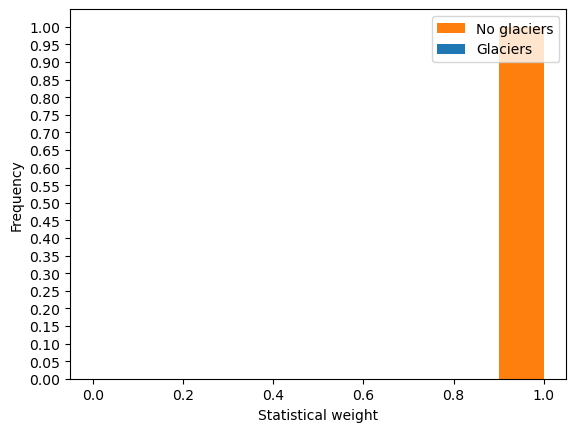


---------------------------------------------------------------------------------------------

The following plot is a histogram of the distribution of glacier simulations wrt to altitude, aspect, slope, and forcing:


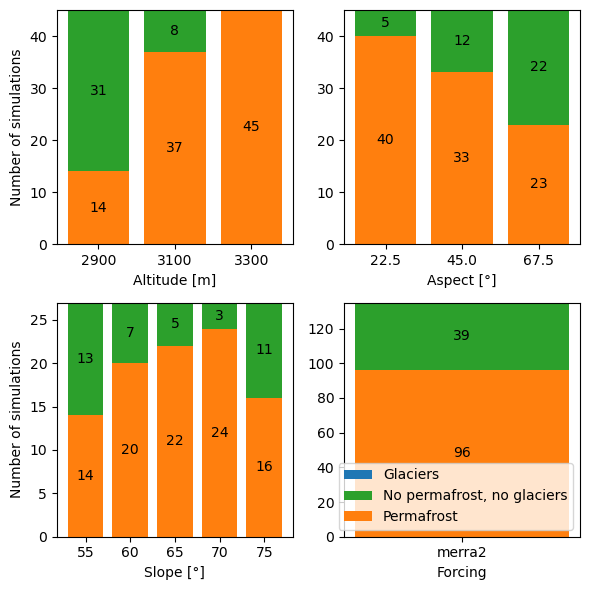


---------------------------------------------------------------------------------------------

Plots of the normalized distance of air and ground temperature, water production, and thaw_depth as a function of time

---------------------------------------------------------------------------------------------

Granularity: week and month side by side


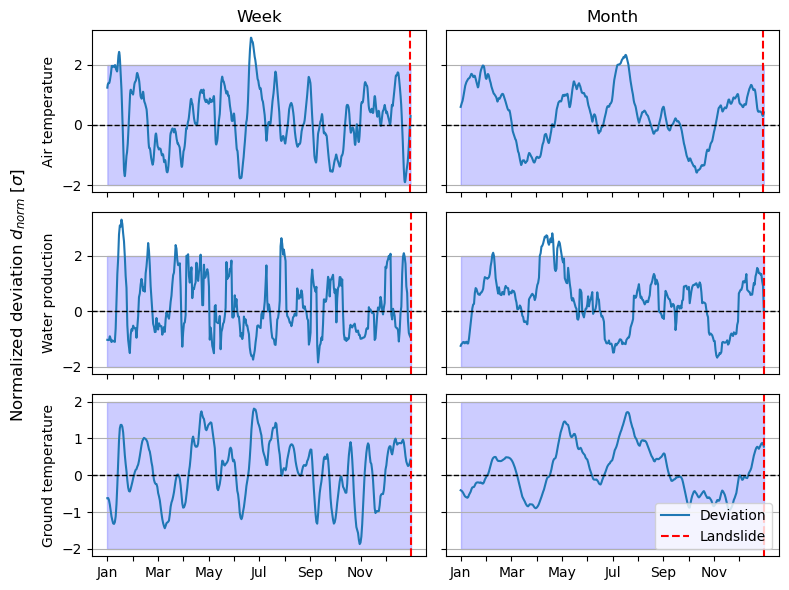


---------------------------------------------------------------------------------------------

Granularity: year, plotted for all years


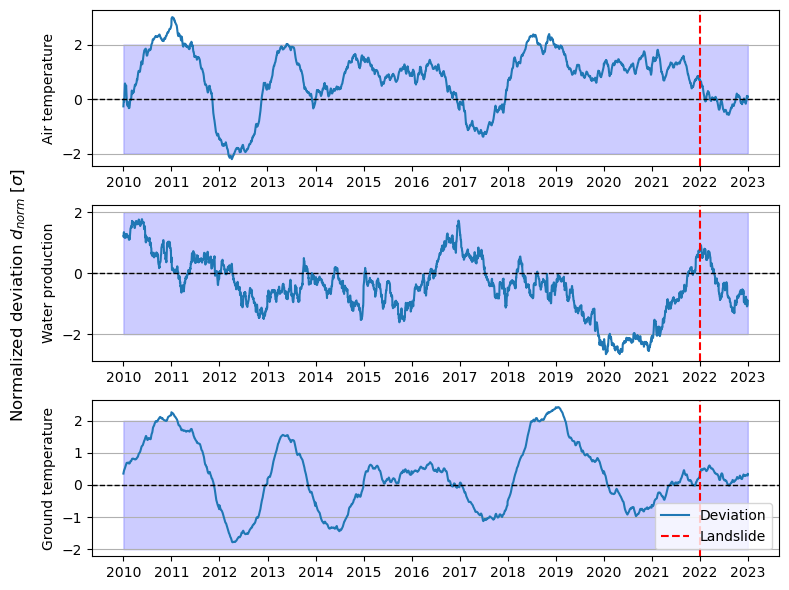


---------------------------------------------------------------------------------------------

Yearly statistics for air and ground surface temperature, and also precipitation and water production


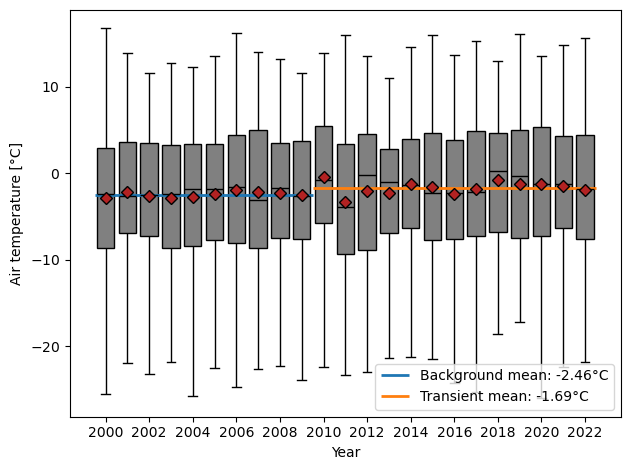

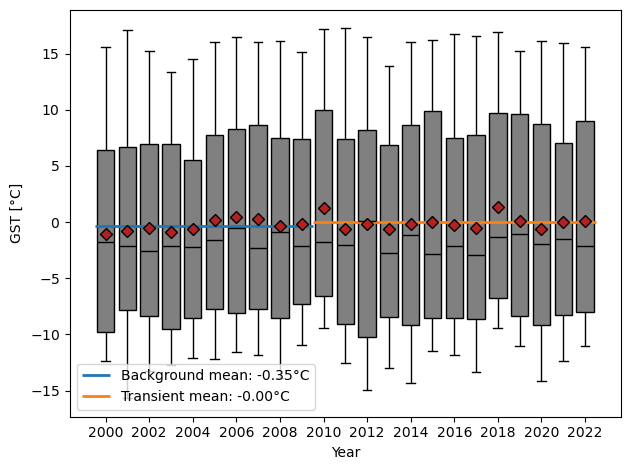

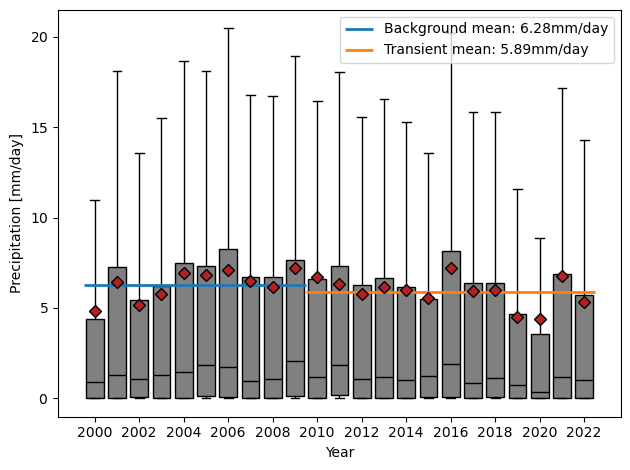

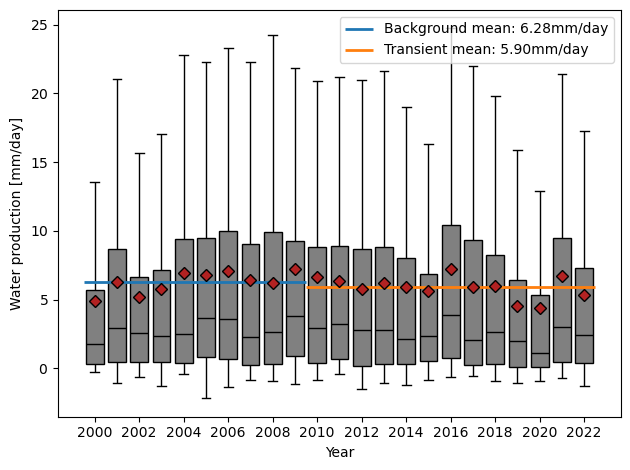


---------------------------------------------------------------------------------------------

Heatmap of the background mean GST as a function of aspect and slope at 3100 m:


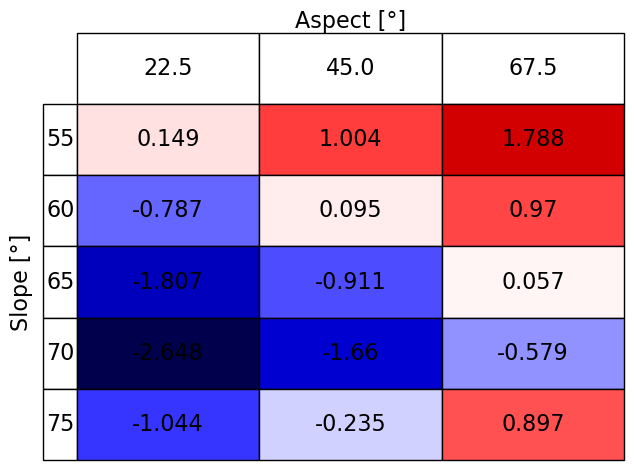


---------------------------------------------------------------------------------------------

Heatmap of the evolution of the mean GST between the background and the transient periods as a function of aspect and slope at 3100 m:


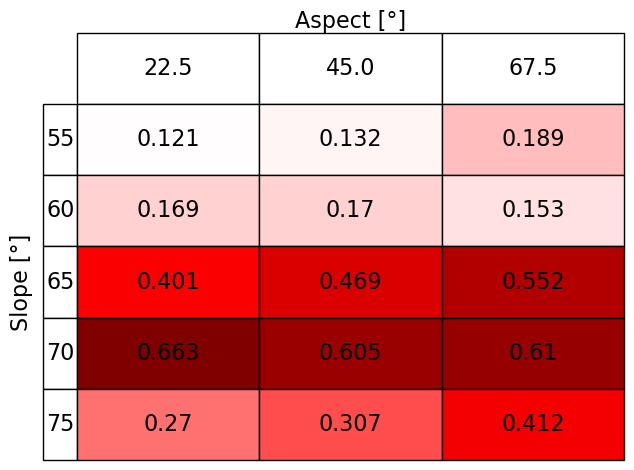


---------------------------------------------------------------------------------------------

Heatmap of the background mean GST and its evolution as a function of aspect and slope at all altitudes


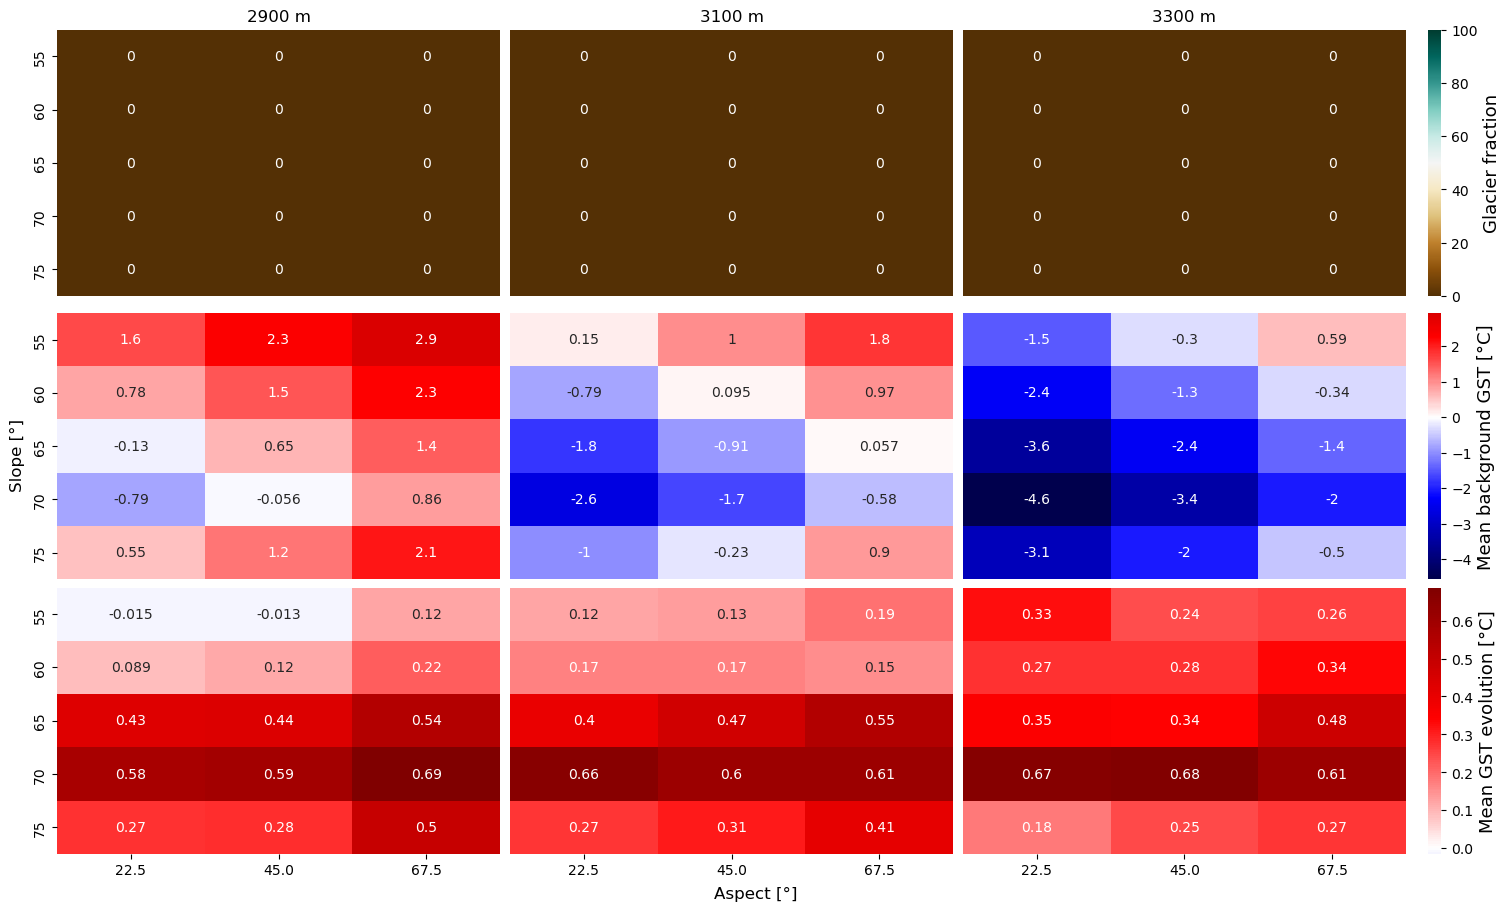


---------------------------------------------------------------------------------------------

Polar heatmap of the background mean GST and its evolution as a function of aspect and slope at all altitude


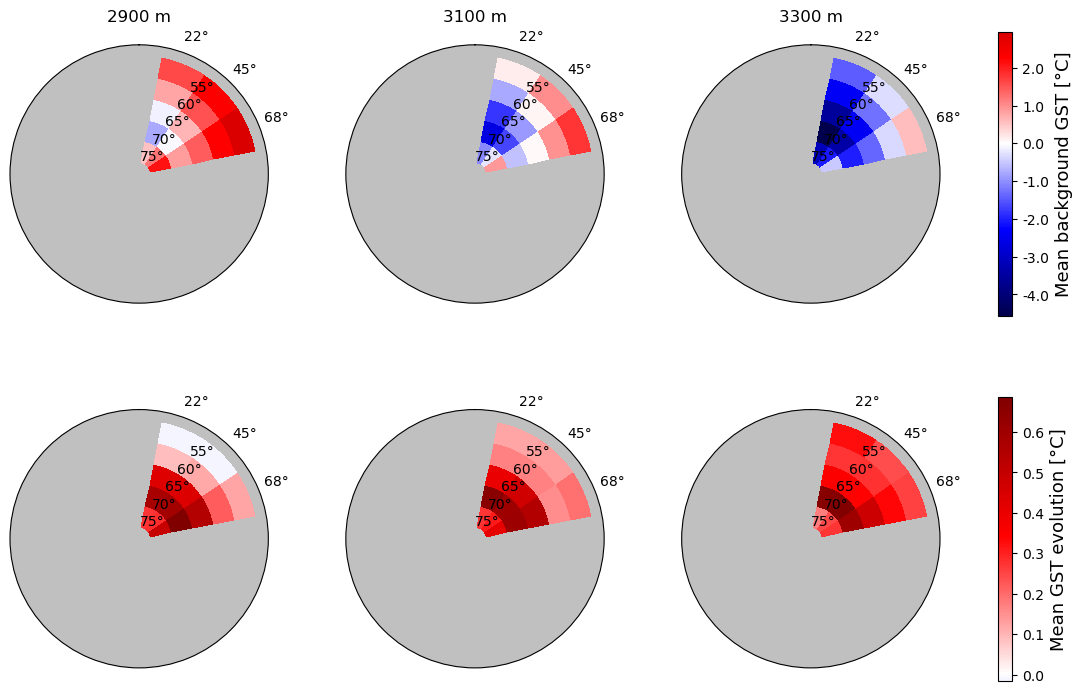


---------------------------------------------------------------------------------------------

Polar plot of the permafrost and glacier spatial distribution as a function of aspect and slope at all altitude


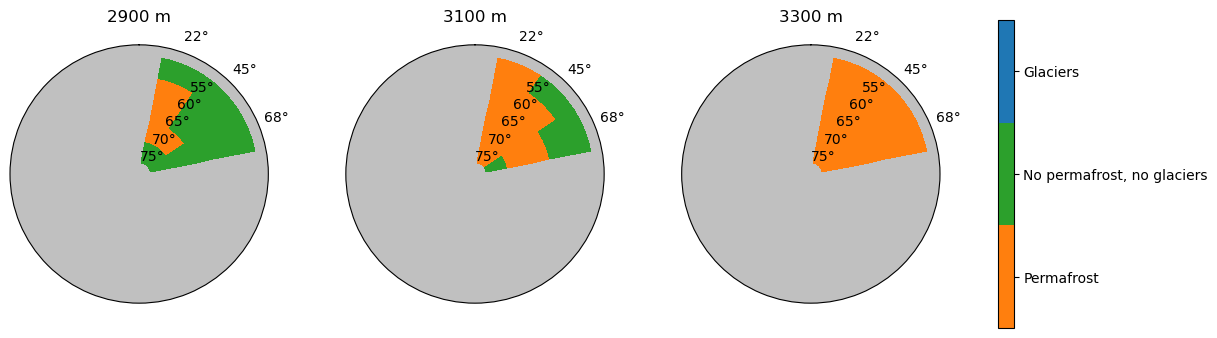


---------------------------------------------------------------------------------------------

CDF of background, transient, and evolution GST:


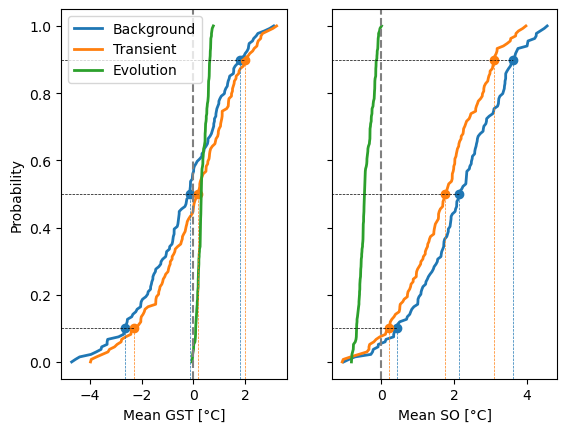


---------------------------------------------------------------------------------------------

Heatmap of 10th, 25th, 50th, 75th, and 90th percentile in background and transient GST, and the difference:


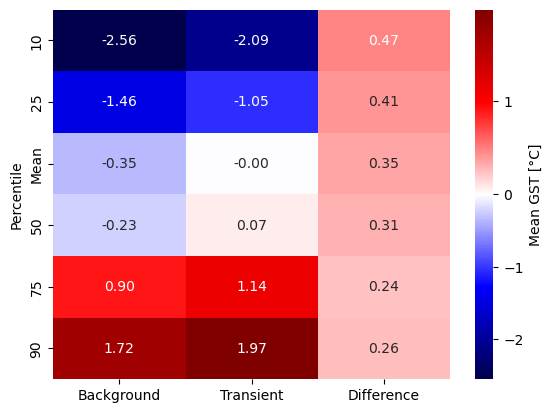


---------------------------------------------------------------------------------------------

Plot of mean GST evolution vs background GST, fit, and binning per 10% quantiles
R-square: 0.1847 , regression slope: -0.0512 , regression intercept: 0.3286


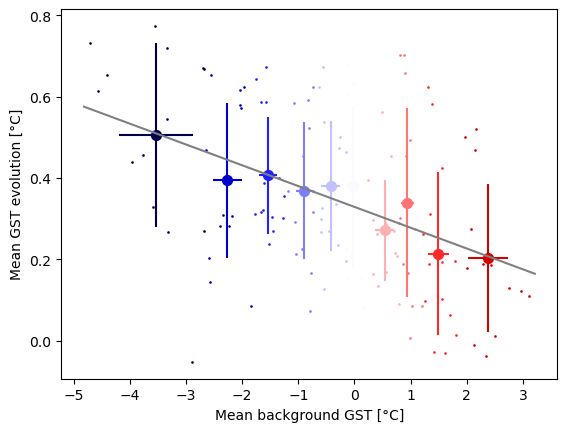


---------------------------------------------------------------------------------------------

Scatter plot of mean background GST vs evolution of mean GST between the background and transient period
altitude: 2900 , R-square: 0.3206 , regression slope: -0.1274 , regression intercept: 0.4689
altitude: 3100 , R-square: 0.3902 , regression slope: -0.1005 , regression intercept: 0.3166
altitude: 3300 , R-square: 0.2586 , regression slope: -0.0579 , regression intercept: 0.2598


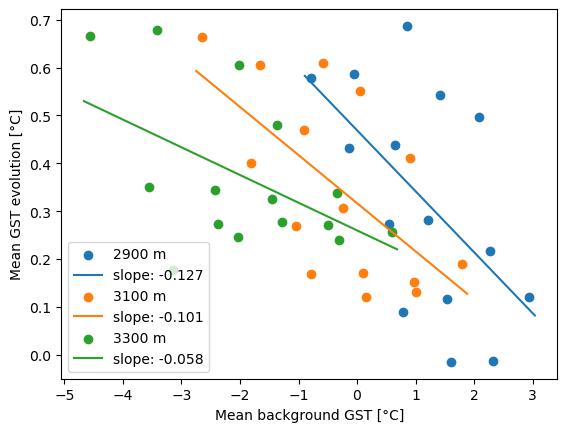


---------------------------------------------------------------------------------------------

Parity plot (statistically-modeled vs numerically-simulated) of background mean GST:


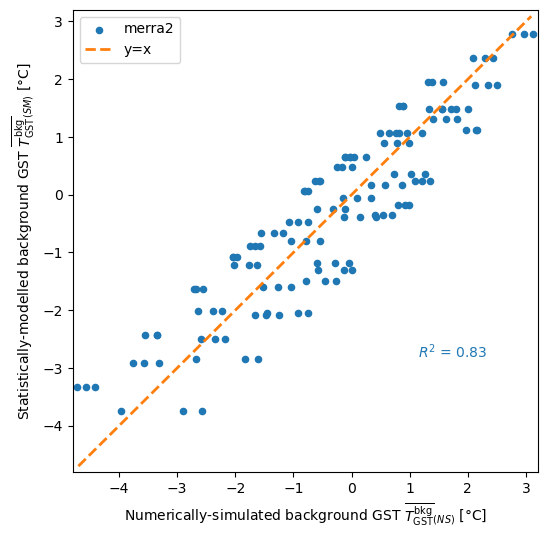

The model is given by the function: 
(offset + c_alt * altitude + c_asp * (altitude - d_alt) * np.cos(aspect * 2 * np.pi / 360) + c_slope * slope)
And the model coefficients are given by: 
  Coefficient       merra2
0      offset    23.497381
1       c_alt    -0.005200
2       d_alt  2127.119771
3       c_asp    -0.003544
4     c_slope    -0.083229

---------------------------------------------------------------------------------------------

Plot of yearly statistics for atmospheric timeseries. Mean and several quantiles for each year:


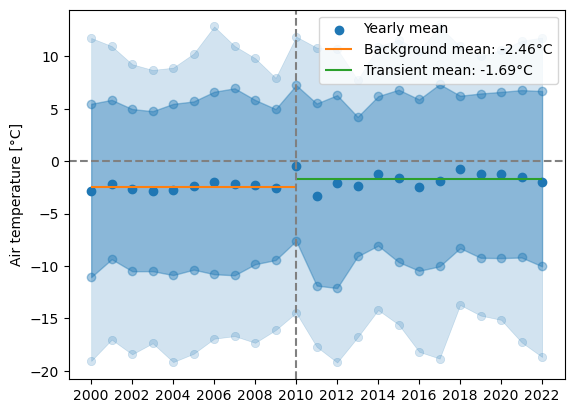

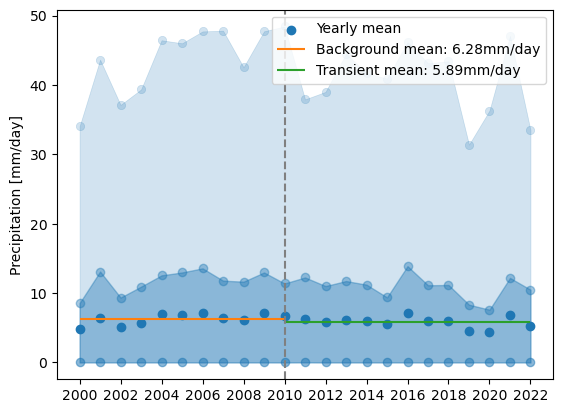


---------------------------------------------------------------------------------------------

Plot of yearly statistics for simulated timeseries. Mean and several quantiles for each year:


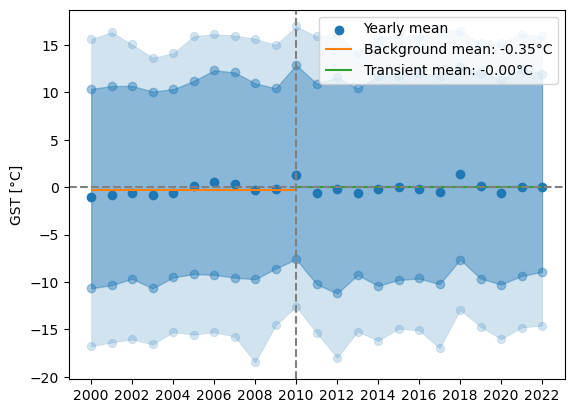

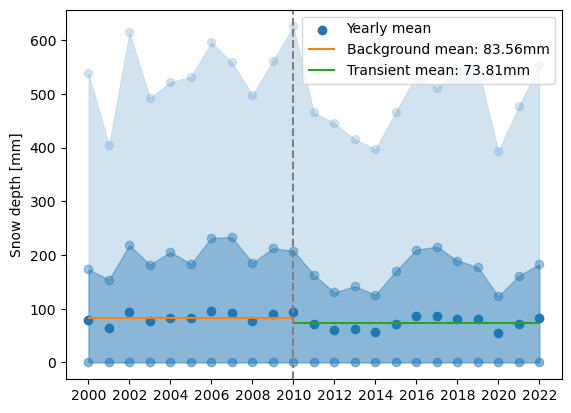

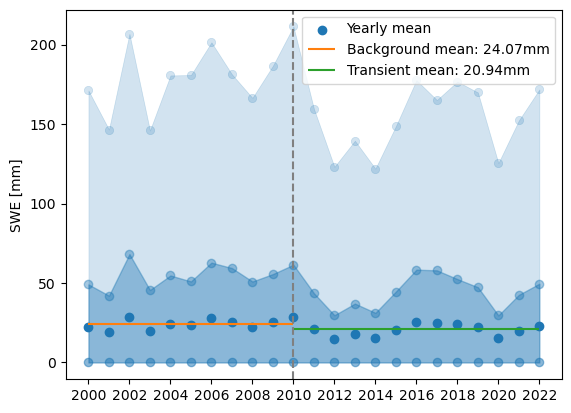


---------------------------------------------------------------------------------------------

Histogram of the evolution of the snow cover (in days) and melt-out date:


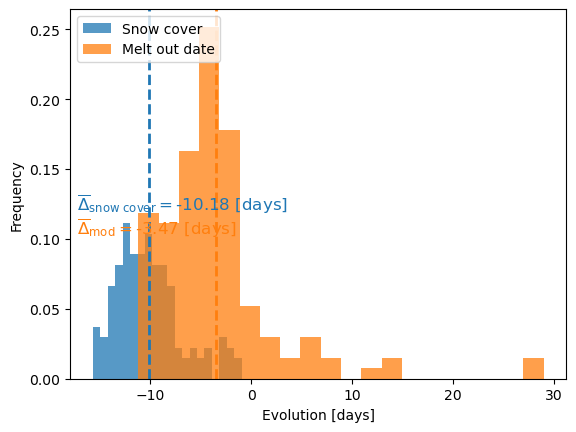


---------------------------------------------------------------------------------------------

Plot of 2 timeseries reduced to a 1-year window with mean and 1- and 2-sigma spread:


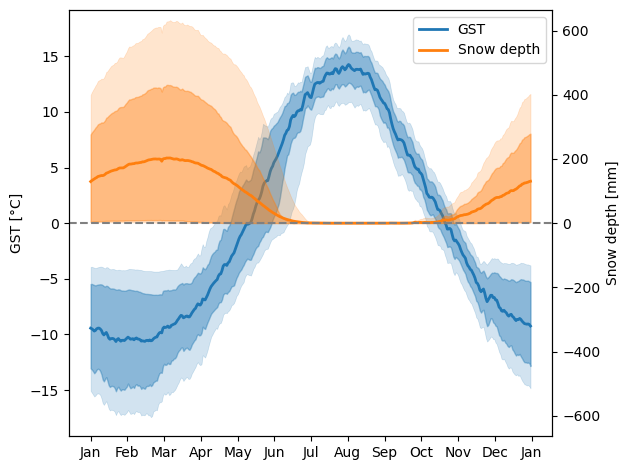


---------------------------------------------------------------------------------------------

Plot of a single timeseries reduced to a 1-year window with mean and 1 and 2-sigma spread, for background and transient periods:


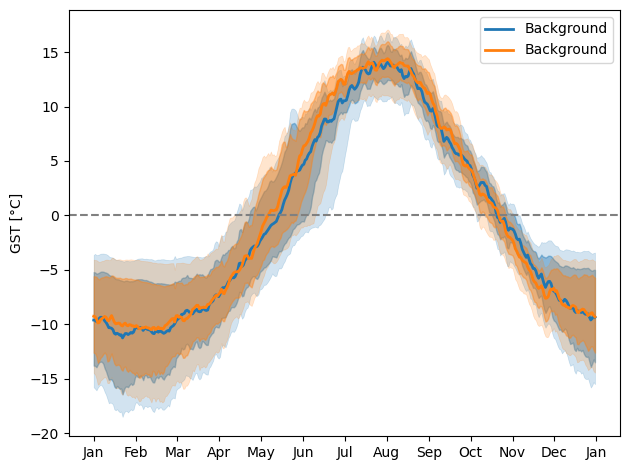

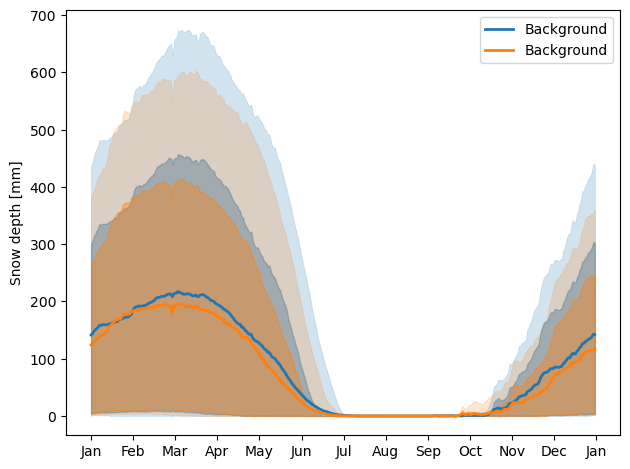

In [3]:
###############
# Ready to go #
###############

# When used for the first time, it createss the pickles
# When the pickles already exist, it simply loads them
# but it's easier to use the function 'load_all_pickles' for that
pkl = get_all_stats(
    forcing_list, path_forcing_list, path_repository, path_ground, path_snow, path_pickle,
    year_bkg_end, year_trans_end, consecutive,
    site, date_event, topo_event,
    glacier, min_glacier_depth)
reanalysis_stats = pkl['reanalysis_stats']
list_valid_sim = pkl['list_valid_sim']
dict_melt_out = pkl['dict_melt_out']
stats_melt_out_dic = pkl['stats_melt_out_dic']
df_stats = pkl['df_stats']
rockfall_values = pkl['rockfall_values']

# this is a function that allows the used to load the pickles in a much simpler way
pkl = load_all_pickles(site, path_pickle)
df = pkl['df']
reanalysis_stats = pkl['reanalysis_stats']
list_valid_sim = pkl['list_valid_sim']
dict_melt_out = pkl['dict_melt_out']
stats_melt_out_dic = pkl['stats_melt_out_dic']
df_stats = pkl['df_stats']

rockfall_values = pkl['rockfall_values']

# Finally, we can produce all the summary plots
plot_all(site, path_forcing_list, path_ground, path_snow, path_swe, path_thaw_depth, path_pickle,
         year_bkg_end, year_trans_end,
         path_horizon=path_horizon, no_weight=True, show_glaciers=True,
         individual_heatmap=True, polar_plots=True, parity_plot=True)